## Importing and cleaning train 

In [7]:
import pandas as pd
train= pd.read_csv('./nlp/tweets.csv', sep='^([^,]+),', engine='python', error_bad_lines=False, encoding='utf-8', index_col=[0])

In [8]:
train = train.reset_index(drop=True)

In [10]:
train.head()

,polarity,statutnull
0,negatif,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,negatif,Est contrarié qu'il ne puisse pas mettre à jou...
2,negatif,J'ai plongé plusieurs fois pour la balle. A ré...
3,negatif,Tout mon corps a des démangeaisons et comme si...
4,negatif,"Non, il ne se comporte pas du tout. je suis en..."


In [11]:
train.columns

Index(['polarity', 'statutnull'], dtype='object')

In [9]:
train['polarity'] = train['polarity'].str.replace("0","negatif").str.replace("4","positif")

In [12]:
index_zero = train[(train['polarity'] != 'positif') & (train['polarity']!= 'negatif')].index

In [13]:
train.drop(index_zero, inplace=True)

In [14]:
train.head()

,polarity,statutnull
0,negatif,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,negatif,Est contrarié qu'il ne puisse pas mettre à jou...
2,negatif,J'ai plongé plusieurs fois pour la balle. A ré...
3,negatif,Tout mon corps a des démangeaisons et comme si...
4,negatif,"Non, il ne se comporte pas du tout. je suis en..."


In [15]:
# pour test, à supprimer
train = train.sample(n=100000)

In [16]:
def clean_up(s):
    import re
    s= re.sub(r'http\S+|(www\.[^\s]+)|(@\S+)',' ',s)
    s=re.sub('[\d]',' ',s)
    s= re.sub('[^\w\s]',' ',s)
    s= re.sub('\s\s+',' ',s)
    s=s.lower().strip()
    return s
def tokenize(s):
    from nltk.tokenize import word_tokenize
    return word_tokenize(s)
def stem(tweet):
    from nltk.stem.snowball import FrenchStemmer
    stemmer = FrenchStemmer()
    return list(map(lambda s: stemmer.stem(s), tweet))
def remove_stopwords(l):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('french')
    stop_words.append('rt')
    return [x for x in l if x not in stop_words]
train.statutnull=train.statutnull.astype(str)

In [17]:
train.statutnull = train.statutnull.apply(lambda s: clean_up(s))

In [18]:
train.statutnull = train.statutnull.apply(lambda s: tokenize(s))

In [19]:
train.statutnull = train.statutnull.apply(lambda s: stem(s))

In [20]:
train.statutnull = train.statutnull.apply(lambda s: remove_stopwords(s))

In [21]:
train.rename(columns={'statutnull':'tweet'},inplace=True)

(-0.5, 799.5, 499.5, -0.5)

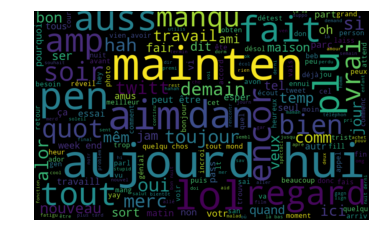

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text= ' '.join([x for text in train.tweet for x in text])
wordcloud = WordCloud(width=800, height=500, random_state=21,max_font_size=110).generate(all_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

In [23]:
train.shape

(100000, 2)

In [24]:
train = train.dropna()

In [28]:
#train['tweet']=' '.join(train['tweet'])
train.reset_index(drop=True).head()

,polarity,tweet
0,negatif,"[impatient, être, assis, dan, circul, chemin, ..."
1,positif,"[ho, hum, temp, cré, chos]"
2,positif,"[hah, i, a, boat, quot, shitoday, woot]"
3,negatif,"[vrai, vrai, envi, retourn, dorm, sinon, fais,..."
4,positif,"[jeu, marin, amis, écran, cinq, fois, somm, gr..."


In [30]:
set(train['polarity'])

{'negatif', 'positif'}

## Building model 

In [31]:
all_words = []
import nltk
NUM_FEATURES = 5000
for index, value in train.tweet.iteritems():
    if value not in all_words:
        all_words += value

top_features = [x[0] for x in nltk.FreqDist(all_words).most_common(NUM_FEATURES)]

KeyboardInterrupt: 

In [ ]:
df=pd.DataFrame.from_dict(nltk.FreqDist(all_words),orient='index')
df.sort_values(by=0, ascending=False).reset_index().head(10)

In [ ]:
top_features[:10]

In [ ]:
def build_features(words):
    features = {}
    for w in top_features:
        features[w] = (w in words)
    return features

In [ ]:
featuresets = []

for index, row in train.iterrows():
    featuresets.append((build_features(row['tweet']), row['polarity']))

In [ ]:
featuresets[:5]

In [ ]:
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
train_set, test = train_test_split(featuresets, test_size=0.2)
classifier = NaiveBayesClassifier.train(train_set)

In [ ]:
classifier.show_most_informative_features(n=25)

In [ ]:
import nltk
nltk.classify.accuracy(classifier, test)

In [ ]:
def clean_up(s):
    import re
    s= re.sub(r'http\S+|(www\.[^\s]+)|(@\S+)',' ',s)
    s=re.sub('[\d]',' ',s)
    s= re.sub('[^\w\s]',' ',s)
    s= re.sub('\s\s+',' ',s)
    s=s.lower().strip()
    from nltk.tokenize import word_tokenize
    s=word_tokenize(s)
    from nltk.stem.snowball import FrenchStemmer
    stemmer = FrenchStemmer()
    s = list(map(lambda x: stemmer.stem(x), s))
    from nltk.corpus import stopwords
    stop_words = stopwords.words('french')
    stop_words.append('rt')
    return [x for x in s if x not in stop_words]

In [ ]:
phrase='Je déteste la grève !'
phrase_clean=clean_up(phrase)
classifier.classify(dict([token,True] for token in phrase_clean))